In [14]:
from libraries.db import DatabaseProxy
from bertopic import BERTopic
import dotenv
from bertopic.representation import OpenAI, KeyBERTInspired
import openai
import os
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
db = DatabaseProxy(reset=True, database="eda")
dotenv.load_dotenv(".envrc")

True

In [9]:
df = pd.read_csv("input/qa-pairs.csv", encoding="latin-1")
db.insert_from_dataframe(df, col_questions="question", col_answers="answer")

# Basic Statistics

In [11]:
df.head()

,question,answer,partners_personnel_selected
0,Checking the financial stability of our suppli...,Our fiscal year begins in January and ends in ...,0
1,How many candidates do you have in your database?,"As of today, 4/25/2023, we have the following:...",0
2,How do you select which candidates are placed ...,Our specialized role known as the client speci...,0
3,How often do you review and refresh your datab...,Our sourcing platform is updated throughout th...,0
4,What type of background and drug testing do yo...,AccuSource is our service provider for backgro...,0


Number of questions

In [12]:
df.shape

(168, 3)

Question length (character and word count)

In [13]:
df["question_length"] = df["question"].apply(len)
df["question_wordcount"] = df["question"].apply(lambda x: len(x.split(" ")))

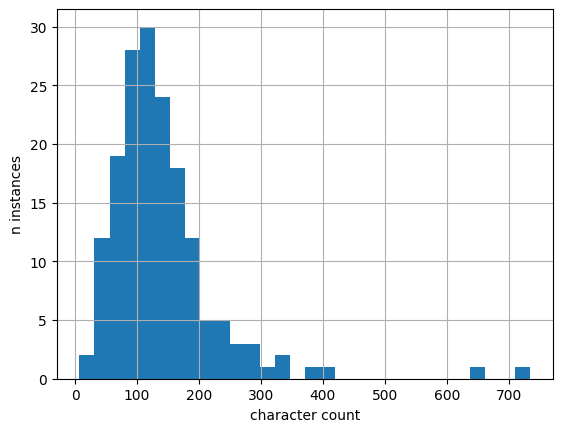

count    168.000000
mean     140.869048
std       91.372539
min        7.000000
25%       91.500000
50%      123.000000
75%      163.750000
max      735.000000
Name: question_length, dtype: float64

In [17]:
df["question_length"].hist(bins=30)
plt.xlabel("character count")
plt.ylabel("n instances")
plt.show()
df["question_length"].describe()

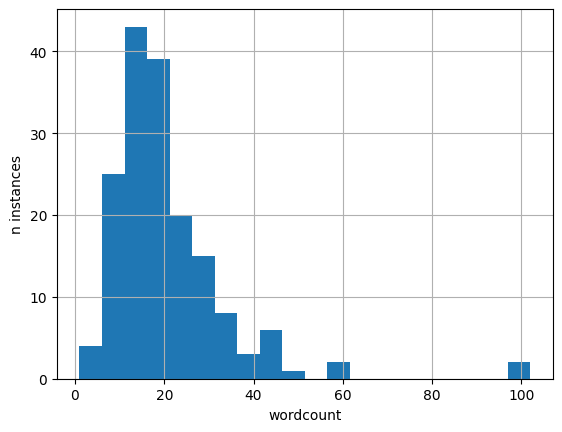

count    168.000000
mean      21.059524
std       13.481725
min        1.000000
25%       14.000000
50%       18.000000
75%       25.000000
max      102.000000
Name: question_wordcount, dtype: float64

In [28]:
df["question_wordcount"].hist(bins=20)
plt.xlabel("wordcount")
plt.ylabel("n instances")
plt.show()
df["question_wordcount"].describe()

Bundled question distribution

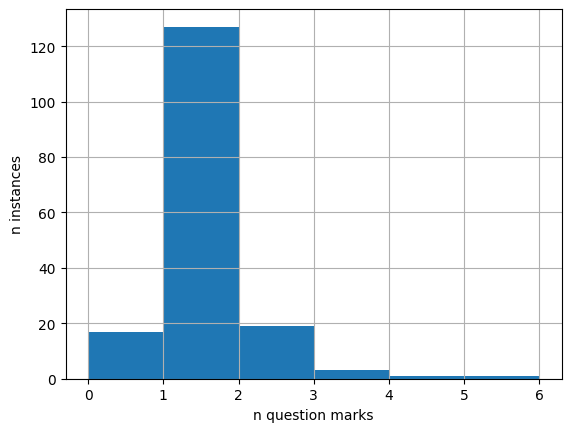

count    168.000000
mean       1.095238
std        0.694185
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: n_bundled_questions, dtype: float64

In [32]:
df["n_bundled_questions"] = df["question"].apply(lambda x: x.count("?"))
df["n_bundled_questions"].hist(bins=6)
plt.xlabel("n question marks")
plt.ylabel("n instances")
plt.show()
df["n_bundled_questions"].describe()

# Topic Modeling

Uses LDA according to the following article: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [ ]:
df_lda = df.copy()

# bertopic

In [ ]:
questions = [q.text for q in db.get_questions()]

In [ ]:
questions[:5]

['Checking the financial stability of our suppliers is part of our due diligence process. To support us in doing this, please tell us when your company financial year runs to and from.',
 'How many candidates do you have in your database?',
 'How do you select which candidates are placed where?  For instance, if two buyers are looking for the same candidate, how do you ultimately determine which company to place that employee with?',
 'How often do you review and refresh your database of candidates?',
 'What type of background and drug testing do you conduct?  How extensive are they? Who is your service provider for background checking?']

In [ ]:
# Fine-tune topic representations with GPT
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(questions)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,82,-1_Document management and security processes,[Document management and security processes],[is there formal user registration process inc...
1,0,30,0_Security and Data Privacy Policies and Proce...,[Security and Data Privacy Policies and Proces...,[Is there a formal and well defined security a...
2,1,24,"1_On-site coordinators, turnover rate, fill ra...","[On-site coordinators, turnover rate, fill rat...",[If you were a provider of ours last season wh...
3,2,18,2_Data Security and Access Controls in Segra O...,[Data Security and Access Controls in Segra Or...,[Is there remote access to the network and sys...
4,3,14,3_Access Control and User Authorization in Sec...,[Access Control and User Authorization in Secu...,[Are critical system files and folders protect...


In [ ]:
for _, row in topic_model.get_topic_info().iterrows():
    print(row["Name"], row["Count"])
    for doc in row["Representative_Docs"]:
        print(f"\t-{doc.strip()}")
    print()

-1_Document management and security processes 82
	-is there formal user registration process include using unique user IDÕs so that users can be linked to and made responsible for their actions and the use of group IDÕs should only be permitted where they are suitable for the work carried out. Please explain
	-Is there a process in place to ensure all employees and external users return the organization's assets on termination of their employment, contract or agreement?
	-Is there procedures in place for handling secure disposal and or return of the customer data upon request or in the case of termination of services? Please explain

0_Security and Data Privacy Policies and Processes 30
	-Is there a formal and well defined security and privacy related reporting process to Management and oversight groups? If yes, please explain the process?
	-Is  a regulatory data privacy and data security compliance assessment against the applicable global and domestic data privacy and data security re